# Random Forest

## Inizializzazione variabili

In [160]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
import matplotlib.pyplot as plt

# Percorso dove salvare l'excel
excel_path = "Excel/RandomForest_Results.xlsx"

# Carica il dataset
df = pd.read_csv("Excel/Clustering.csv")

# Dividi X e Y
Y = df['Has_Diagnostics']
X = df.drop(columns=['Has_Diagnostics'])

# Funzione per metriche
def get_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return cm, acc, prec, rec, f1

### Riempimento valori null come media

In [170]:
df_media = df.fillna(df.mean(numeric_only=True))

# Dividi X e Y
del X, Y
Y = df_media['Has_Diagnostics']
X = df_media.drop(columns=['Has_Diagnostics'])

### Riempimento valori null come mediana

In [193]:
df_mediana = df.fillna(df.median(numeric_only=True))

# Dividi X e Y
del X, Y
Y = df_mediana['Has_Diagnostics']
X = df_mediana.drop(columns=['Has_Diagnostics'])

### Riempimento valori null con KNNImputer

In [211]:
# Rimuovi momentaneamente X e Y
df_temp = df.copy()

# Crea un imputatore KNN
imputer = KNNImputer(n_neighbors=5)

# Applica l'imputazione solo sulle colonne numeriche
df_imputed_array = imputer.fit_transform(df_temp.select_dtypes(include='number'))

# Ricrea il DataFrame con le stesse colonne
df_imputed = pd.DataFrame(df_imputed_array, columns=df_temp.select_dtypes(include='number').columns)

# Se ci sono colonne non numeriche, le aggiungiamo di nuovo (senza modificarle)
for col in df_temp.columns:
    if col not in df_imputed.columns:
        df_imputed[col] = df_temp[col]

# Dividi X e Y
del X, Y
Y = df_imputed['Has_Diagnostics']
X = df_imputed.drop(columns=['Has_Diagnostics'])

### Riempimento valori null con IterativeImputer

In [220]:
# Rimuovi momentaneamente X e Y
df_temp = df.copy()

# Crea un imputatore iterativo
imputer = IterativeImputer(max_iter=10, random_state=42)

# Applica l'imputazione solo sulle colonne numeriche
df_imputed_array = imputer.fit_transform(df_temp.select_dtypes(include='number'))

# Ricrea il DataFrame con le stesse colonne
df_imputed = pd.DataFrame(df_imputed_array, columns=df_temp.select_dtypes(include='number').columns)

# Se ci sono colonne non numeriche, le aggiungiamo di nuovo (senza modificarle)
for col in df_temp.columns:
    if col not in df_imputed.columns:
        df_imputed[col] = df_temp[col]

# Dividi X e Y
del X, Y
Y = df_imputed['Has_Diagnostics']
X = df_imputed.drop(columns=['Has_Diagnostics'])

## Metodo dell 80/20

=== VALIDAZIONE 80/20 ===
Accuracy: 0.7034
Precision: 0.6791
Recall: 0.7034
F1-Score: 0.6805


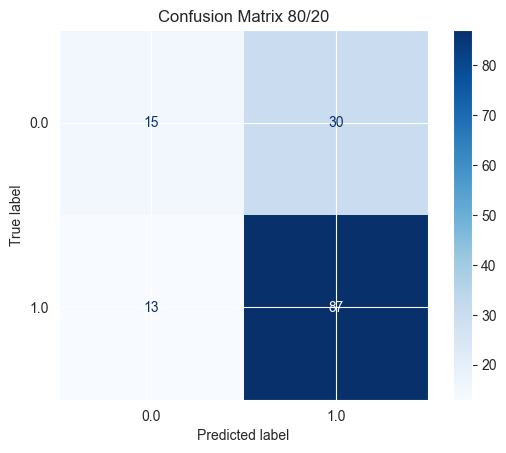

✅ Risultati 80/20 salvati su Excel.


In [113]:
print("=== VALIDAZIONE 80/20 ===")
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm, acc, prec, rec, f1 = get_metrics(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix 80/20")
plt.show()

# Calcola importanza delle feature
importances = clf.feature_importances_
features = X.columns
importances_dict = {f'Imp_{feat}': [imp] for feat, imp in zip(features, importances)}

# Prepara il DataFrame da salvare
df_split = pd.DataFrame({
    'Prova': [Prova],
    'n_estimators': [n_estimators],
    'max_depth': [max_depth],
    'Accuracy': [acc],
    'Precision': [prec],
    'Recall': [rec],
    'F1-Score': [f1],
    'Confusion_Matrix': [cm.tolist()],
    ' ': [None]
} | importances_dict)  # Unione dizionari

# Aggiungi a eventuali dati già presenti
if os.path.exists(excel_path):
    with pd.ExcelFile(excel_path) as reader:
        if 'Split_80_20' in reader.sheet_names:
            prev_data = pd.read_excel(reader, sheet_name='Split_80_20')
            df_split = pd.concat([prev_data, df_split], ignore_index=True)

# Scrivi sul file
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_split.to_excel(writer, sheet_name='Split_80_20', index=False)

print("✅ Risultati 80/20 salvati su Excel.")

## K-Fold cross recognition

=== VALIDAZIONE K-FOLD ===

--- Fold 1 ---
Accuracy: 0.6897
Precision: 0.6405
Recall: 0.6897
F1-Score: 0.6140


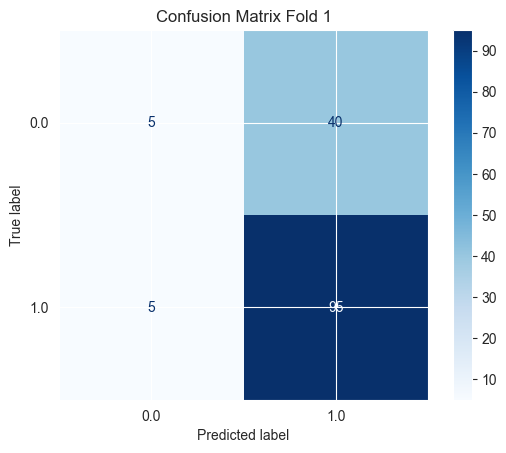


--- Fold 2 ---
Accuracy: 0.6966
Precision: 0.6631
Recall: 0.6966
F1-Score: 0.6576


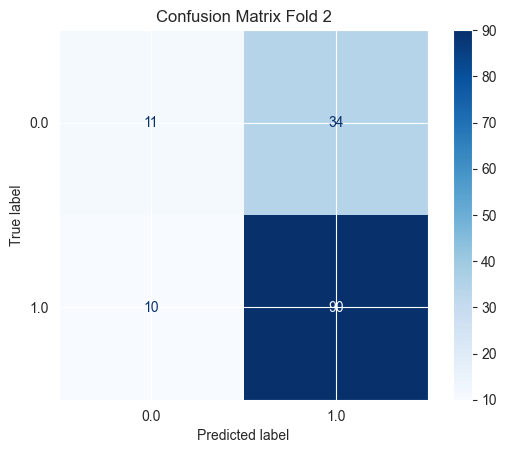


--- Fold 3 ---
Accuracy: 0.7103
Precision: 0.6849
Recall: 0.7103
F1-Score: 0.6568


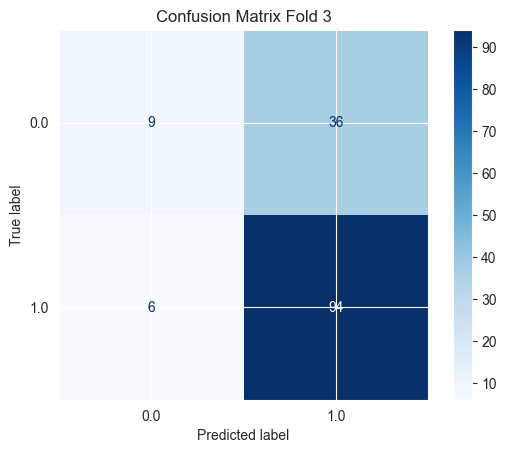


--- Fold 4 ---
Accuracy: 0.7083
Precision: 0.6865
Recall: 0.7083
F1-Score: 0.6877


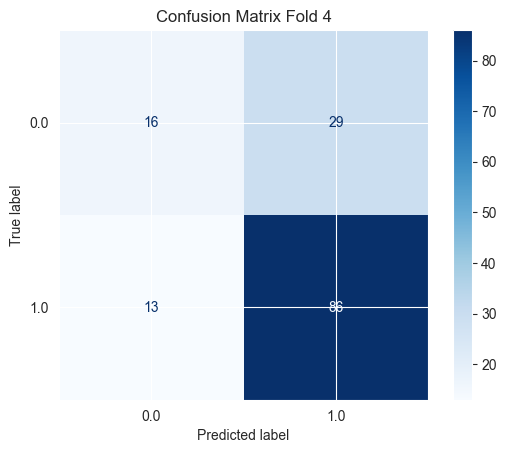


--- Fold 5 ---
Accuracy: 0.6736
Precision: 0.6359
Recall: 0.6736
F1-Score: 0.6396


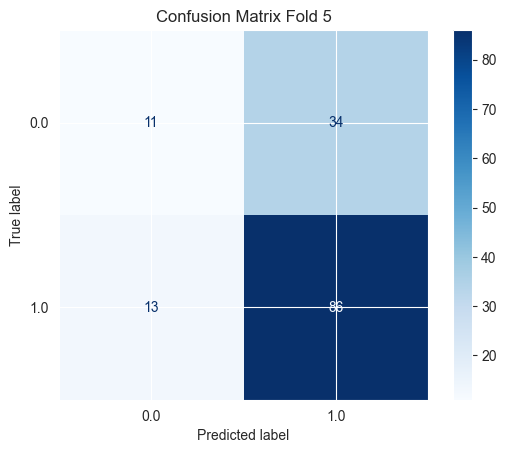

✅ Risultati K-Fold salvati su Excel.


In [114]:
print("=== VALIDAZIONE K-FOLD ===")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for i, (train_index, test_index) in enumerate(kf.split(X, Y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm, acc, prec, rec, f1 = get_metrics(y_test, y_pred)

    print(f"\n--- Fold {i} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix Fold {i}")
    plt.show()

    # Calcola importanza delle feature
    importances = clf.feature_importances_
    features = X.columns
    importances_dict = {f'Imp_{feat}': imp for feat, imp in zip(features, importances)}

    # Salva tutti i dati in un'unica riga
    fold_results.append({
        'Prova': Prova,
        'KFold' : i,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Confusion_Matrix': cm.tolist(),
        ' ': [None]
    }  | importances_dict)

df_kfold = pd.DataFrame(fold_results)

# Aggiungi a eventuali dati già presenti
if os.path.exists(excel_path):
    with pd.ExcelFile(excel_path) as reader:
        if 'KFold_CV' in reader.sheet_names:
            prev_kfold = pd.read_excel(reader, sheet_name='KFold_CV')
            df_kfold = pd.concat([prev_kfold, df_kfold], ignore_index=True)

# Scrivi sul file
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_kfold.to_excel(writer, sheet_name='KFold_CV', index=False)

print("✅ Risultati K-Fold salvati su Excel.")

## TRAIN-FOLD / TEST-HOLDOUT validation

In [227]:
Prova = 20
n_estimators = 300
max_depth = 10


--- Fold 1 (train su fold, test fisso) ---
Accuracy: 0.6966
Precision: 0.6718
Recall: 0.6966
F1-Score: 0.6750


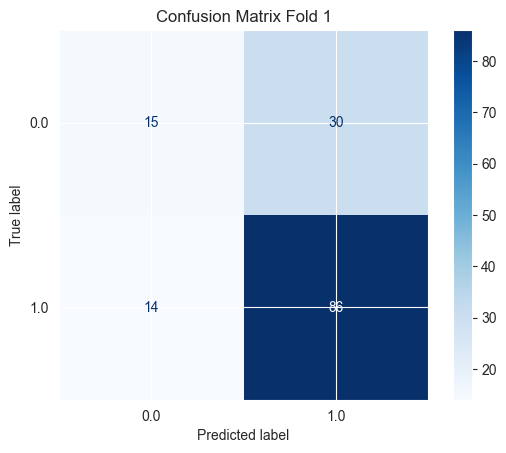


--- Fold 2 (train su fold, test fisso) ---
Accuracy: 0.7103
Precision: 0.6885
Recall: 0.7103
F1-Score: 0.6898


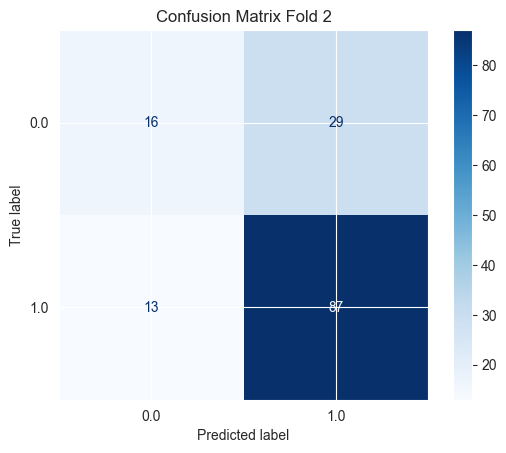


--- Fold 3 (train su fold, test fisso) ---
Accuracy: 0.6966
Precision: 0.6718
Recall: 0.6966
F1-Score: 0.6750


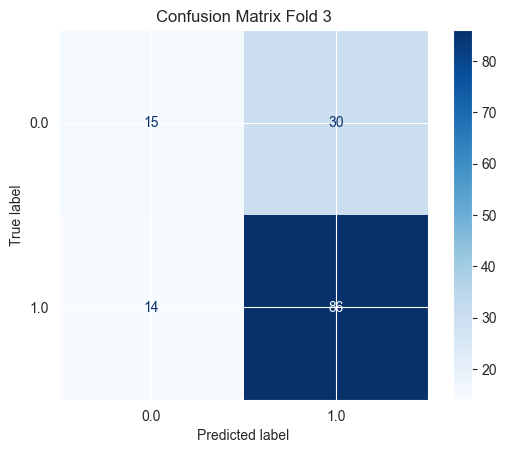


--- Fold 4 (train su fold, test fisso) ---
Accuracy: 0.6966
Precision: 0.6694
Recall: 0.6966
F1-Score: 0.6711


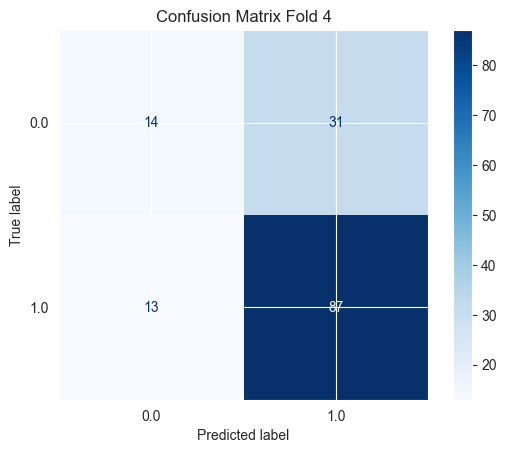


--- Fold 5 (train su fold, test fisso) ---
Accuracy: 0.7034
Precision: 0.6836
Recall: 0.7034
F1-Score: 0.6875


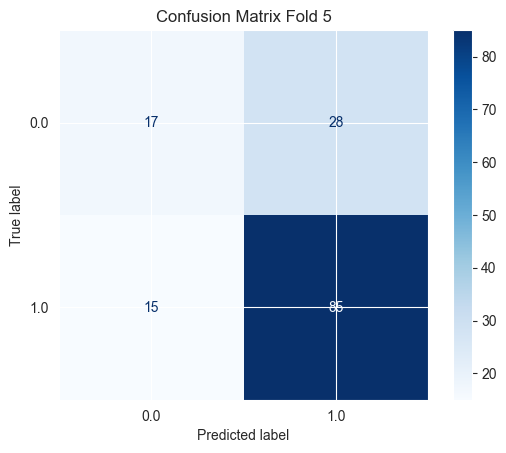

✅ Risultati nested fold salvati su Excel.


In [228]:
val_results = []
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

for i, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), start=1):
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]

    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    clf.fit(X_fold_train, y_fold_train)

    # Si testa sempre sullo stesso 20%
    y_pred = clf.predict(X_test)

    cm, acc, prec, rec, f1 = get_metrics(y_test, y_pred)

    print(f"\n--- Fold {i} (train su fold, test fisso) ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix Fold {i}")
    plt.show()

    # Feature importances
    importances = clf.feature_importances_
    importances_dict = {f'Imp_{feat}': imp for feat, imp in zip(X.columns, importances)}

    # Salva i risultati del fold
    val_results.append({
        'Prova': Prova,
        'KFold' : i,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Confusion_Matrix': cm.tolist(),
        ' ': None,  # cella vuota per separare le metriche dalle importances
        **importances_dict
    })

# Crea il DataFrame
df_nested = pd.DataFrame(val_results)

# Se esiste già, aggiungi i dati al foglio
if os.path.exists(excel_path):
    with pd.ExcelFile(excel_path) as reader:
        if 'TrainFold_TestFixed' in reader.sheet_names:
            prev_nested = pd.read_excel(reader, sheet_name='TrainFold_TestFixed')
            df_nested = pd.concat([prev_nested, df_nested], ignore_index=True)
            
# Salva su Excel
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_nested.to_excel(writer, sheet_name='TrainFold_TestFixed', index=False)

print("✅ Risultati nested fold salvati su Excel.")